<a href="https://colab.research.google.com/github/zhuangzhuang1211/Deep_Learning_CPMG_Analysis/blob/add-license-1/HPC_model_N32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

____
### This tutorial provides each step to excute proposed procedures of Hyperfine Parametere Classifier (HPC) models for the CPMG signal in N32.
### (From generating datasets to bulding and training the proposed models)

____
Note1: To run this notebook, first click "Open in playgound" tab above. You may need "Chrome" browser and "Gmail account". Then in each cell, press 'Shift + Enter'

Note2: It doesn't need any packages or programs and also doesn't store any files in your device.

In [ ]:
# Setting up requirement files
!git clone https://github.com/kyunghoon-jung/Deep_Learning_CPMG_Analysis.git 

Cloning into 'Deep_Learning_CPMG_Analysis'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 382 (delta 145), reused 94 (delta 48), pack-reused 147
Receiving objects: 100% (382/382), 279.29 MiB | 13.86 MiB/s, done.
Resolving deltas: 100% (206/206), done.
Checking out files: 100% (65/65), done.


In [ ]:
cd Deep_Learning_CPMG_Analysis/

/content/Deep_Learning_CPMG_Analysis


### Now, we'll generate training datasets in the image representation depicted in Fig.2 of the maintext.
____

Below are the steps to configure basic parameters.

In [ ]:
from imports.models import *
from imports.utils import *
import adabound as Adabound

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import glob 
import sys 
import time
np.set_printoptions(suppress=True)

In [ ]:
from multiprocessing import Pool 
POOL_PROCESS = 23  
FILE_GEN_INDEX = 2 
pool = Pool(processes=POOL_PROCESS)  

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle
import itertools

In [ ]:
total_indices = np.load('/content/Deep_Learning_CPMG_Analysis/tutorial_data/total_indices_v4_full.npy', allow_pickle=True).item() 

In [ ]:
AB_lists_dic = np.load('/content/Deep_Learning_CPMG_Analysis/tutorial_data/AB_target_dic_v4_s0.npy', allow_pickle=True).item() 
for i in range(1, 16):
    temp = np.load('/content/Deep_Learning_CPMG_Analysis/tutorial_data/AB_target_dic_v4_s{}.npy'.format(i), allow_pickle=True).item()  
    AB_lists_dic.update(temp)

In [ ]:
print("Generation of datasets excuted.", time.asctime())
tic = time.time()

time_resolution = 0.004
time_data = np.arange(0, 60, time_resolution)

PRE_PROCESS = False
PRE_SCALE = 1

MAGNETIC_FIELD = 403.553                        # Unit: Gauss
GYRO_MAGNETIC_RATIO = 1.0705*1000               # Unit: Herts 
WL_VALUE = MAGNETIC_FIELD*GYRO_MAGNETIC_RATIO*2*np.pi

CUDA_DEVICE = 0
N_PULSE = 32

IMAGE_WIDTH = 10
TIME_RANGE  = 10000

# These are the parameters that determine the range which is evaluated by the model.
# Just for now, we set the range from 10000 Hz to 10500 Hz for A, and from 12000 Hz to 70000 Hz for B.
# So, the models is trained to tell if spins exist or not in that range.
# Note!: You can set 'how many models' to be built by varying 'A_step', also you can modify the ranges to be evaluted by varying below parameters. 

A_init  = 10000  # a lower bound of the range 
A_final = 10500  # a upper bound of the range
A_step  = 250  # a step size of one model.
A_range = 200  # a range which is covered by each model.
B_init  = 12000       
B_final = 70000       
noise_scale = 0.05  # Addding noises to the simulated data. It does not significantly affect the results. You may try other values.  
SAVE_DIR_NAME = './tutorial_data/'

ADD_EXISTING_SPIN = False

model_lists = get_AB_model_lists(A_init, A_final, A_step, A_range, B_init, B_final)
print("=============== Model lists ===============\n [A_init, A_final, B_init, B_final]\n", model_lists)
print("\nThe number of models:", len(model_lists))
print("The range of one model:", A_range, 'Hz')

Generation of datasets excuted. Mon Jun 15 09:03:44 2020
=============== Model lists ===============
 [A_init, A_final, B_init, B_final]
 [[10000 10200 12000 70000]
 [10250 10450 12000 70000]
 [10500 10700 12000 70000]]

The number of models: 3
The range of one model: 200 Hz


### We're going to generate datasets for the model of [10000, 10200, 12000, 70000]

It means the model covers the range 10000 ~ 10200 Hz for A and 12000~70000 Hz for B.

The graph below shows spins with the target periods in the range above. 

Note: It's an active graph. You can zoom in and out.

In [ ]:
A_index_1 = 10000
A_index_2 = 10050
A_index_3 = 10100
A_index_4 = 10150
A_index_5 = 10200
layout = go.Layout( 
    title = 'Target spins in this model', 
    xaxis = dict(title="A (Hz)"),
    yaxis = dict(title="B (Hz)"),
)
fig = go.Figure(layout=layout)
fig.add_traces([
    go.Scatter(x=AB_lists_dic[A_index_1][:,0], y=AB_lists_dic[A_index_1][:,1]),
    go.Scatter(x=AB_lists_dic[A_index_2][:,0], y=AB_lists_dic[A_index_2][:,1]),
    go.Scatter(x=AB_lists_dic[A_index_3][:,0], y=AB_lists_dic[A_index_3][:,1]),
    go.Scatter(x=AB_lists_dic[A_index_4][:,0], y=AB_lists_dic[A_index_4][:,1]),
    go.Scatter(x=AB_lists_dic[A_index_5][:,0], y=AB_lists_dic[A_index_5][:,1]),
])
fig.show()

So, if the training is done properly, the model will be able to tell whether the spin exists on those coutour lines (B>12000 Hz) or not.

Note: Parameters here are not annotated in detail. <br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; You can check anotated codes in https://github.com/kyunghoon-jung/Deep_Learning_CPMG_Analysis 


In [ ]:
for model_idx, [A_first, A_end, B_first, B_end] in enumerate(model_lists[:1]):

    print("========================================================================")
    print('A_first:{}, A_end:{}, B_first:{}, B_end:{}'.format(A_first, A_end, B_first, B_end))
    print("TIME_RANGE, B_first, B_final, IMAGE_WIDTH", TIME_RANGE, B_first, B_final, IMAGE_WIDTH)
    print("========================================================================")
    A_num = 1
    B_num = 1
    A_resol, B_resol = 50, B_end-B_first+500

    A_idx_list = np.arange(A_first, A_end+A_resol, A_num*A_resol)
    if (B_end-B_first)%B_resol==0:
        B_idx_list = np.arange(B_first, B_end+B_resol, B_num*B_resol)
    else:
        B_idx_list = np.arange(B_first, B_end, B_num*B_resol)
    AB_idx_set = [[A_idx, B_idx] for A_idx, B_idx in itertools.product(A_idx_list, B_idx_list)]
    
    if abs(AB_idx_set[0][0]) < 10000: continue
    A_side_num = 8
    A_side_resol = 600

    B_target_gap = 0
    A_target_margin = 25
    A_side_margin = 300
    A_far_side_margin = 5000
    distance_btw_target_side = 650
    class_num = A_num*B_num + 1
    side_candi_num = 5   

    image_width = IMAGE_WIDTH 
    class_num = A_num*B_num + 1
    cpu_num_for_multi = 20
    batch_for_multi = 128
    class_batch = cpu_num_for_multi*batch_for_multi

    spin_zero_scale = {'same':0.5, 'side':0.20, 'mid':0.05, 'far':0.05}

    if N_PULSE==32:
        B_side_min, B_side_max = 6000, 70000
        B_side_gap = 5000
        B_target_gap = 1000

    elif N_PULSE==256:
        B_side_min, B_side_max = 1000, 25000
        B_side_gap = 500
        B_target_gap = 0

    if ((N_PULSE == 32) & (B_first<11000)):
        PRE_PROCESS = True
        PRE_SCALE = 8  
        print("==================== PRE_PROCESSING:True =====================")

    args = (AB_lists_dic, N_PULSE, A_num, B_num, A_resol, B_resol, A_side_num, A_side_resol, B_side_min,
                B_side_max, B_target_gap, B_side_gap, A_target_margin, A_side_margin, A_far_side_margin,
                class_batch, class_num, spin_zero_scale, distance_btw_target_side, side_candi_num) 

    TPk_AB_candi, Y_train_arr, _ = gen_TPk_AB_candidates(AB_idx_set, False, *args)
    if ADD_EXISTING_SPIN == True:
        TPk_AB_candi = return_existing_spins_wrt_margins(deno_pred_N32_B12000_above, TPk_AB_candi, A_existing_margin, B_existing_margin)

    total_idx = []
    for AB_temp_set in AB_idx_set:
        A_temp_index = AB_temp_set[0]
        temp_idx = get_model_index(total_indices, A_temp_index, time_thres_idx=TIME_RANGE-20, image_width=image_width)
        temp_idx = return_index_without_A_idx(total_indices, temp_idx, 0, TIME_RANGE, width=25)[0]
        total_idx.append(temp_idx.shape[0])
    cut_idx = min(total_idx)

    X_train_arr = np.zeros((class_num, len(AB_idx_set)*class_batch, cut_idx, 2*image_width+1))
    X_train_TPk_arr = np.zeros((class_num, len(AB_idx_set)*class_batch, 1))
    
    for idx1, [A_idx, B_idx] in enumerate(AB_idx_set):
        model_index = get_model_index(total_indices, A_idx, time_thres_idx=TIME_RANGE-20, image_width=image_width)
        model_index = return_index_without_A_idx(total_indices, model_index, 0, TIME_RANGE, width=25)[0]
        model_index = model_index[:cut_idx, :] 

        for class_idx in range(class_num):
            for idx2 in range(cpu_num_for_multi):
                AB_lists_batch = TPk_AB_candi[class_idx, idx1*class_batch+idx2*batch_for_multi:idx1*class_batch+(idx2+1)*batch_for_multi]
                globals()["pool_{}".format(idx2)] = pool.apply_async(gen_M_arr_batch, [AB_lists_batch, model_index, time_data[:TIME_RANGE], 
                                                                                        WL_VALUE, N_PULSE, PRE_PROCESS, PRE_SCALE, 
                                                                                        noise_scale])

            for idx3 in range(cpu_num_for_multi):  
                X_train_arr[class_idx, idx1*class_batch+idx3*batch_for_multi:idx1*class_batch+(idx3+1)*batch_for_multi] = globals()["pool_{}".format(idx3)].get(timeout=None) 
                X_train_TPk_arr[class_idx, idx1*class_batch+idx3*batch_for_multi:idx1*class_batch+(idx3+1)*batch_for_multi, 0] = A_idx
            print("_", end=' ') 

print("\nData Generation Completed.")

A_first:10000, A_end:10200, B_first:12000, B_end:70000
TIME_RANGE, B_first, B_final, IMAGE_WIDTH 10000 12000 70000 10
_ _ _ _ _ _ _ _ _ _ 

### From now, let's define HPC model and train it. 

  For simplicity, here we made two classes (class1, class2) 
  
  Class1 corresponds to 'No target spin'
  Class2 corresponds to 'One target spin'

  ___
  Here is shown the samples of Class 1, Class 2.
  
  Note: you can vary the image width by varying the variable of "IMAGE_WIDTH" above.

Text(0.5, 1.0, 'Class 2')

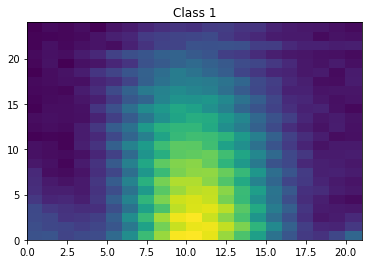

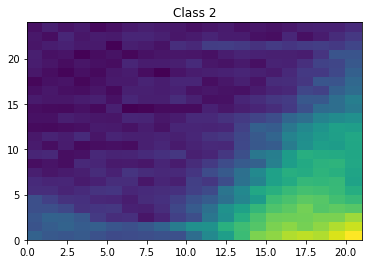

In [ ]:
idx = np.random.randint(X_train_arr.shape[1])
plt.figure(facecolor='w')
plt.pcolor(X_train_arr[1][idx])
plt.title("Class 1") 

idx = np.random.randint(X_train_arr.shape[1])
plt.figure(facecolor='w')
plt.pcolor(X_train_arr[0][idx])
plt.title("Class 2") 

____
For example, if a predicted confidence score is (0.0001, 0.993), then it infers there exist no target spin. And if a confidence score is (0.991, 0.000001), then it suggests that there exist 1 target spin.
___


In [ ]:
torch.cuda.set_device(device=CUDA_DEVICE) 
epochs = 15
valid_batch = 4096
valid_mini_batch = 1024

# Reshape
X_train_arr = X_train_arr.reshape(class_num*len(AB_idx_set)*class_batch, model_index.flatten().shape[0]) 
Y_train_arr = Y_train_arr.reshape(class_num*len(AB_idx_set)*class_batch, class_num) 

X_train_arr, Y_train_arr = shuffle(X_train_arr, Y_train_arr)
model = HPC(X_train_arr.shape[1], Y_train_arr.shape[1]).cuda()
try:
    model(torch.Tensor(X_train_arr[:5]).cuda()) 
except:
    raise NameError("The input shape should be revised")

total_parameter = sum(p.numel() for p in model.parameters()) 
print('total_parameter: ', total_parameter / 1000000, 'M')


total_parameter:  3.66541 M


In [ ]:
MODEL_PATH = SAVE_DIR_NAME
if not os.path.exists(MODEL_PATH): os.mkdir(MODEL_PATH)

mini_batch_list = [2048]  
learning_rate_list = [5e-6] 
op_list = [['Adabound', [30,15,7,1]]] 
criterion = nn.BCELoss().cuda()
hyperparameter_set = [[mini_batch, learning_rate, selected_optim_name] for mini_batch, learning_rate, selected_optim_name in itertools.product(mini_batch_list, learning_rate_list, op_list)]
print("==================== A_idx: {}, B_idx: {} ======================".format(A_first, B_first))

total_loss, total_val_loss, total_acc, trained_model = train(MODEL_PATH, N_PULSE, X_train_arr, Y_train_arr, model, hyperparameter_set, criterion,
                                                            epochs, valid_batch, valid_mini_batch)
min_A = np.min(np.array(AB_idx_set)[:,0])
max_A = np.max(np.array(AB_idx_set)[:,0])

model.load_state_dict(torch.load(trained_model[0][0])) 
model.eval()
print("Model loaded as evalutation mode. Model path:", trained_model[0][0])

==================== A_idx: 10000, B_idx: 12000 ======================
train_batch:  21504 valid_batch:  4096


 Training Start:  Mon Jun 15 09:25:17 2020
 mini_batch: 2048  | learning_rate:  5e-06  | selected_optim_name:  ['Adabound', [30, 15, 7, 1]]  |


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning:

This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)



Epoch:    1  | Loss = 0.22699 | Val_loss: 0.47613 | Accuracy: 90.92 % | time: 0.299(s) | lr:  5e-06
Epoch:    2  | Loss = 0.07677 | Val_loss: 0.26490 | Accuracy: 95.70 % | time: 0.12(s) | lr:  5e-06
Epoch:    3  | Loss = 0.05574 | Val_loss: 0.11758 | Accuracy: 97.36 % | time: 0.119(s) | lr:  5e-06
Epoch:    4  | Loss = 0.04851 | Val_loss: 0.07359 | Accuracy: 98.73 % | time: 0.119(s) | lr:  5e-06
Epoch:    5  | Loss = 0.04683 | Val_loss: 0.05209 | Accuracy: 99.02 % | time: 0.118(s) | lr:  5e-06
Epoch:    6  | Loss = 0.04592 | Val_loss: 0.05350 | Accuracy: 98.73 % | time: 0.119(s) | lr:  1.75e-06
Epoch:    7  | Loss = 0.04649 | Val_loss: 0.04327 | Accuracy: 99.12 % | time: 0.117(s) | lr:  1.75e-06
Epoch:    8  | Loss = 0.04362 | Val_loss: 0.05021 | Accuracy: 98.83 % | time: 0.118(s) | lr:  6.125e-07
Epoch:    9  | Loss = 0.04704 | Val_loss: 0.04829 | Accuracy: 98.93 % | time: 0.118(s) | lr:  2.1437499999999996e-07
Epoch:   10  | Loss = 0.04576 | Val_loss: 0.04860 | Accuracy: 98.93 % | ti

____
### If you see the results with 'Accuracy' around 98~99%, then the model is trained enough.  

Text(0.5, 1.0, 'Classification Accuracy (%)')

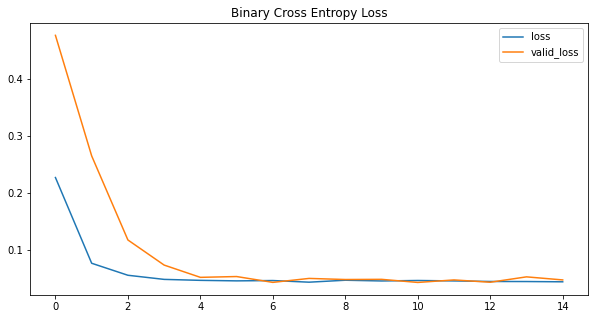

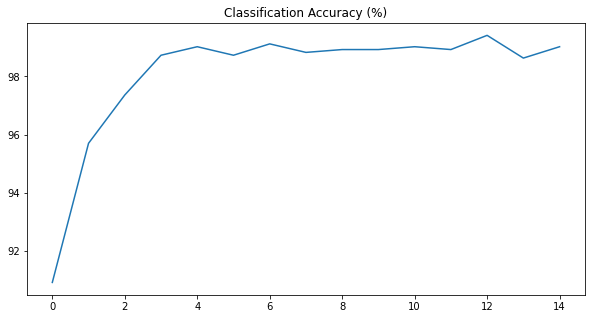

In [ ]:
plt.figure(facecolor='w', figsize=(10, 5))
plt.plot(total_loss, label='loss') 
plt.plot(total_val_loss, label='valid_loss')
plt.title('Binary Cross Entropy Loss')
plt.legend()
plt.figure(facecolor='w', figsize=(10, 5))
plt.plot(total_acc)
plt.title('Classification Accuracy (%)')

___
### Let's evaluate the simulated CPMG signal with using the trained model which covers the following range. 


Note: The simulated data will be intentionally include (or exclude) a spin in the range below. 

========================================================================<br>
A_range:10000 ~ 10200 (Hz)<br>
B_range:12000 ~ 70000 (Hz)<br>
========================================================================<br>

In [ ]:
A_index = 10050
target_spin = AB_lists_dic[A_index][500] / 1000
total_spins = np.array([
                        target_spin,
                        [41, 53],
                        [18, 11],
                        [-17, 18],
                        [-23, 15],
                        [-35, 28],
]) 

Text(0.5, 1.0, 'Test image')

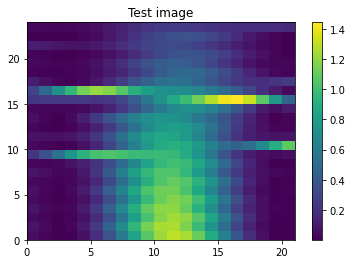

In [ ]:
M_values = M_list_return(time_data*1e-6, WL_VALUE, total_spins*2000*np.pi, N_PULSE)
M_modified = 1 - M_values[model_index]
plt.figure(facecolor='w')
plt.pcolor(M_modified)
plt.colorbar()
plt.title('Test image')

____

*   It obviously shows a vertical line at the center, which indicates the signal has a spin with the same period as the target period. <br>
: So, the predicted confidence score should have the highest value in Class 2 dimension.



In [ ]:
M_modified_tensor = torch.Tensor(M_modified.flatten()).cuda()
M_modified_tensor = torch.unsqueeze(M_modified_tensor, 0)
model(M_modified_tensor)

tensor([[0.0294, 0.9562]], device='cuda:0', grad_fn=<SigmoidBackward>)

___
It shows the highest confidence score in 2nd dimension which indicates there is one target spin.

In [ ]:
total_spins = np.array([
                        [41, 53],
                        [18, 11],
                        [-17, 18],
                        [-23, 15],
                        [-35, 28],
]) 

Text(0.5, 1.0, 'Test image')

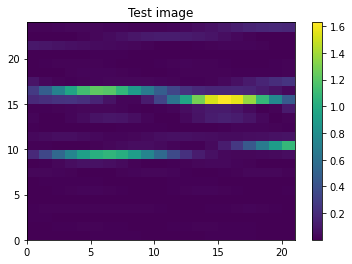

In [ ]:
M_values = M_list_return(time_data*1e-6, WL_VALUE, total_spins*2000*np.pi, N_PULSE)
M_modified = 1 - M_values[model_index]
plt.figure(facecolor='w')
plt.pcolor(M_modified)
plt.colorbar()
plt.title('Test image')

In [ ]:
M_modified_tensor = torch.Tensor(M_modified.flatten()).cuda()
M_modified_tensor = torch.unsqueeze(M_modified_tensor, 0)
model(M_modified_tensor)

tensor([[0.9931, 0.0045]], device='cuda:0', grad_fn=<SigmoidBackward>)

___
It shows the highest confidence score in 1st dimension which indicates there is no target spin.